In [1]:
%config Completer.use_jedi = False

In [2]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
tf.enable_v2_behavior()
tfd = tfp.distributions
tfb = tfp.bijectors

In [4]:
df = pd.read_csv("data/pageviews-20190101-20201110.csv")
df.head()

,Date,Vacation
0,2019-01-01,247
1,2019-01-02,358
2,2019-01-03,400
3,2019-01-04,338
4,2019-01-05,276


In [5]:
ts = df.Vacation

In [6]:
ts

0      247
1      358
2      400
3      338
4      276
      ... 
675    185
676    121
677    161
678    146
679    179
Name: Vacation, Length: 680, dtype: int64

In [7]:
data = np.log(ts)

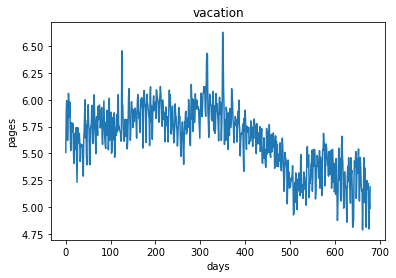

In [8]:
date = np.arange(0,680)
plt.plot(data)
plt.ylabel('pages')
plt.xlabel('days')
plt.title('vacation')
plt.show()

In [11]:
def vcm(fn):
    vacation_cnt = tfd.JointDistributionNamed(dict(
        e=tfd.Exponential(rate=1.),
        l=tfd.Exponential(rate=1.),
        s=tfd.Uniform(0., high=len(date)),
        d_t=lambda s, l, e: tfd.Independent(
            tfd.Poisson(rate=fn(np.arange(len(date)), s, l, e)),
            reinterpreted_batch_ndims=1)
    ))
    return vacation_cnt

In [13]:
def vacation_rate_switch(ys, s, l, e):
    return tf.where(ys < s, e, l)

In [14]:
def vacation_rate_sigmoid(ys, s, l, e):
    return e + tf.sigmoid(ys-s) * (l-e)

In [15]:
model_switch = vcm(vacation_rate_switch)
model_sigmoid = vcm(vacation_rate_sigmoid)

In [16]:
def target_log_prob_fn(model, s, e, l):
    return model.log_prob(s=s, e=e, l=l, d_t=data)

In [17]:
models = [model_switch, model_sigmoid]

In [18]:
print([target_log_prob_fn(m, 40., 3., .9).numpy() for m in models])  # Somewhat likely result
print([target_log_prob_fn(m, 60., 1., 5.).numpy() for m in models])  # Rather unlikely result
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models]) # Impossible result

[-4851.3438, -4844.7095]
[-1573.2362, -1568.2694]
[-inf, -inf]


In [19]:
num_results = 10000
num_burnin_steps = 0

@tf.function(autograph=False, experimental_compile=True)
def make_chain(target_log_prob_fn):
    kernel = tfp.mcmc.TransformedTransitionKernel(
       inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3),
       bijector=[
          tfb.Sigmoid(low=0., high=tf.cast(len(date), dtype=tf.float32)),
          tfb.Softplus(),
          tfb.Softplus(),
      ])
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8*num_burnin_steps))

    states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_pre_covid_rate'),
          tf.ones([], name='init_post_covid_rate'),
      ],
      trace_fn=None,
      kernel=kernel)
    return states

switch_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples = [s.numpy() for s in make_chain(
    lambda *args: target_log_prob_fn(model_sigmoid, *args))]

switchpoint, pre_covid_rate, post_covid_rate = zip(
    switch_samples, sigmoid_samples)

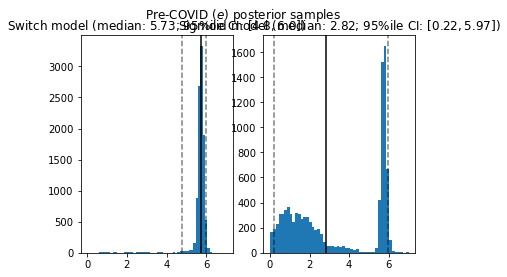

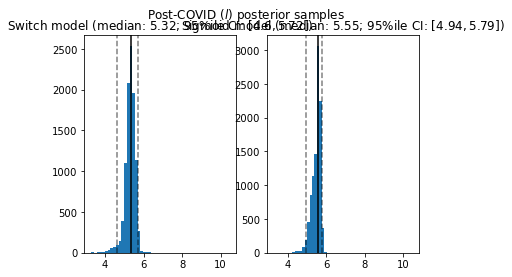

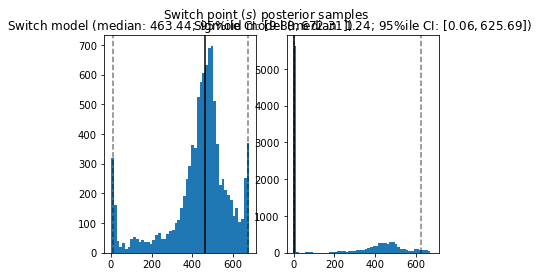

In [20]:
def _desc(v):
    return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Pre-COVID ($e$) posterior samples', pre_covid_rate),
    ('Post-COVID ($l$) posterior samples', post_covid_rate),
    ('Switch point ($s$) posterior samples', date[0] + switchpoint),
]:
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
    for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
        a = ax[i]
        a.hist(v[i], bins=50)
        a.axvline(x=np.percentile(v[i], 50), color='k')
        a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
        a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
        a.set_title(m + ' model ' + _desc(v[i]))
    fig.suptitle(t)
    plt.show()